In [266]:
import numpy as np
import HMM
from nltk.tokenize import TweetTokenizer
import matplotlib.pyplot as plt

import os
from IPython.display import HTML

from HMM_helper import (
    text_to_wordcloud,
    states_to_wordclouds,
    parse_observations,
    sample_sentence,
    visualize_sparsities,
    animate_emission
)

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Tokenization of Sonnets and Generation of Poet-Specific Corpus

In [10]:
# Return a list of poems, each poem is a string

# For Shakespeare
def shakespeare_extract_poetry_list(file):
    text = file.read()
    poetry_list = text.lower().split("\n\n")
    tknzr = TweetTokenizer()

    for i in range(len(poetry_list)):
        start_line = 2 if i != 0 else 1
        lines = poetry_list[i].split("\n")
        poetry_list[i] = tknzr.tokenize(' NEWLINE '.join(lines[start_line:]))

    return poetry_list


# For Spencer
def spencer_extract_poetry_list(file):
    text = file.read()
    poetry_list = text.lower().split("\n\n")
    tknzr = TweetTokenizer()

    for i in range(len(poetry_list) - 1, -1, -1):
        if i % 2 == 0:
            poetry_list.remove(poetry_list[i])

        else:
            lines = poetry_list[i].split("\n")
            poetry_list[i] = tknzr.tokenize(' NEWLINE '.join(lines))

    return poetry_list

In [11]:
# Tokenize words in txt file to create corpus
# Assign them to integer states

def preprocess(shakespeare=True):
    # Tokenize words from file
    if shakespeare:
        file = "data/shakespeare.txt" 
        with open(file) as f:
            poetry_list_by_line = shakespeare_extract_poetry_list(f)
    else:
        file = "data/spenser.txt"
        with open(file) as f:
            poetry_list_by_line = spencer_extract_poetry_list(f)
            
    # Transform lines of poetry into set of words
    corpus = []
    for i in range(len(poetry_list_by_line)):
        corpus += poetry_list_by_line[i]
    corpus = list(set(corpus))
    
    # Turn corpus into integer states
    obs_map = {}
    obs_counter = 0
    
    for word in corpus:
        if word not in obs_map:
            obs_map[word] = obs_counter
            obs_counter += 1
    
    return poetry_list_by_line, obs_map

In [50]:
# Convert poems into sequences of states
def poem_to_seq(poem, obs_map):
    obs = np.zeros(len(poem), dtype=int)
    
    for i in range(len(poem)):
        obs[i] = int(obs_map[poem[i]])
        
    return obs

In [44]:
# Reverse map from words to integer states
def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

In [57]:
# Turn sequence of states into words
def seq_to_poem(seq, obs_map_r):
    poem = []
    
    for i in range(len(seq)):
        poem.append(obs_map_r[seq[i]])
        
    return poem

In [51]:
# Shakespearean sonnets
poems_shakespeare, word_map_shakespeare = preprocess()

# Spencerean sonnets
poems_spencer, word_map_spencer = preprocess(shakespeare=False)

In [52]:
# Get Shakespeare sequence states
seqs_shakespeare = []
for i in range(len(poems_shakespeare)):
    seqs_shakespeare.append(poem_to_seq(poems_shakespeare[i],
                                        word_map_shakespeare)
                           )
    
# Get Spencer sequence states
seqs_spencer = []
for i in range(len(poems_spencer)):
    seqs_spencer.append(poem_to_seq(poems_spencer[i],
                                    word_map_spencer)
                       )

In [191]:
# Reverse word maps
state_map_shakespeare = obs_map_reverser(word_map_shakespeare)
state_map_spencer = obs_map_reverser(word_map_spencer)

In [192]:
word_map_sonnet = {}
w_counter = 0
# Combine Shakespearean and Spencerian ditionaries
for i in range(len(state_map_shakespeare)):
    word = state_map_shakespeare[i]
    if word not in word_map_sonnet:
            word_map_sonnet[word] = w_counter
            w_counter += 1
            
for i in range(len(state_map_spencer)):
    word = state_map_spencer[i]
    if word not in word_map_sonnet:
            word_map_sonnet[word] = w_counter
            w_counter += 1         

In [193]:
# Combine poem training set
all_sonnets = poems_shakespeare + poems_spencer
seqs_all = []
for i in range(len(all_sonnets)):
    seqs_all.append(poem_to_seq(all_sonnets[i],
                                word_map_sonnet)
                       )

In [201]:
state_map_all = obs_map_reverser(word_map_sonnet)

# Unsupervised Learning of HMMs For Sonnets

For unsupervised training of the HMMs, we made the decision to allow for 18 hidden states. The rational behind this decision is that linguists generally recognize about 17 different parts of speech:

1. adjectives
2.        adverbs
3.        nouns
4.        verbs (except auxiliary verbs)
5.        interjections
6.        auxiliary verbs
7.        clitics
8.        coverbs
9.        conjunctions
10.        determiners (articles, quantifiers, demonstrative adjectives, and possessive adjectives)
11.        particles
12.        measure words or classifiers
13.        adpositions (prepositions, postpositions, and circumpositions)
14.        preverbs
15.        pronouns
16.        contractions
17.        cardinal numbers

so we allowed for a single hidden state for each part of speech. The final (18th) hidden state is reserved for punctuation such as commas, periods, and new line statements. Our hope was that by allowing enough hidden states for different parts of speech and punctuation, the HMM would be able to more accurately learn the statistical structure of the sonnets, preserving both grammar and syntax.

In [66]:
hmm_shakespeare = HMM.unsupervised_HMM(seqs_shakespeare, 18, 1000)

In [67]:
hmm_spencer = HMM.unsupervised_HMM(seqs_spencer, 18, 1000)

In [194]:
hmm_full = HMM.unsupervised_HMM(seqs_all, 18, 1000)

In [195]:
Reg_O_shakespeare = np.array(hmm_shakespeare.O)
Reg_O_spencer = np.array(hmm_spencer.O)
Reg_O_all = np.array(hmm_full.O)

Reg_A_shakespeare = np.array(hmm_shakespeare.A)
Reg_A_spencer = np.array(hmm_spencer.A)
Reg_A_all = np.array(hmm_full.A)

### Low Number of Hidden States

In [74]:
hmm_shakespeare_short = HMM.unsupervised_HMM(seqs_shakespeare, 5, 100)

In [80]:
hmm_spencer_short = HMM.unsupervised_HMM(seqs_spencer, 5, 100)

In [196]:
hmm_full_short = HMM.unsupervised_HMM(seqs_all, 5, 100)

In [197]:
Short_O_shakespeare = np.array(hmm_shakespeare_short.O)
Short_O_spencer = np.array(hmm_spencer_short.O)
Short_O_all = np.array(hmm_full_short.O)

Short_A_shakespeare = np.array(hmm_shakespeare_short.A)
Short_A_spencer = np.array(hmm_spencer_short.A)
Short_A_all = np.array(hmm_full_short.A)

### Large Number of Hidden States

In [81]:
hmm_shakespeare_long = HMM.unsupervised_HMM(seqs_shakespeare, 50, 100)

In [82]:
hmm_spencer_long = HMM.unsupervised_HMM(seqs_spencer, 50, 100)

In [198]:
hmm_full_long = HMM.unsupervised_HMM(seqs_all, 50, 100)

In [199]:
Long_O_shakespeare = np.array(hmm_shakespeare_long.O)
Long_O_spencer = np.array(hmm_spencer_long.O)
Long_O_all = np.array(hmm_full_long.O)

Long_A_shakespeare = np.array(hmm_shakespeare_long.A)
Long_A_spencer = np.array(hmm_spencer_long.A)
Long_A_all = np.array(hmm_full_long.A)

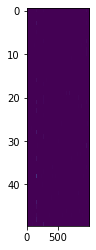

In [200]:
plt.imshow(Long_O_shakespeare[:, 2000:3000], aspect=70)

# Generating Sonnets From Emission Sequences

In [321]:
def print_poem_hmm(hmm, state_map):
    seq, st = hmm.generate_emission(140)
    poem = seq_to_poem(seq, state_map)
    for j in range(len(poem)):
        if poem[j] == 'NEWLINE': poem[j] = '\n'
    for i in range(14):
        print(' '.join(poem[i*10:(i+1)*10]))
        print('\n')
        if (i+1)%4==0:
            print('\n')

In [157]:
def print_poem_lines_hmm(hmm, state_map):
    for i in range(14):
        seq, st = hmm.generate_emission(10)
        poem = seq_to_poem(seq, state_map)
        for j in range(len(poem)):
            if poem[j] == 'NEWLINE': poem[j] = '\n'
        print(' '.join(poem))
        print('\n')
        if (i+1)%4==0:
            print('\n')

## Shakespeare

### 18 State HMM

In [158]:
print_poem_lines_hmm(hmm_shakespeare, state_map_shakespeare)

we change his eclipses thy wasted your thy their thee


look a cure make true mayst winter's i his as


thee all-eating sullied fortune nimble hot world's their be did


and cure be tis thee see true ears form think




every double thy loved contracted thine your do winter's not


day art whose the hot thy woe the willing a


in his his be get me your saw their them


lamb by wilt be self-doing the my your thee physicians




love such either's be be sullen time your am faults


and the all may such thy all sweet every mine


to this bath themselves not not crying weary truly art


wane eyes have her do thyself is thine never thee




imprint desired my bareness manners the there ( grown my


warm prevent'st my true thy survive sluttish lose be loved




In [322]:
print_poem_hmm(hmm_shakespeare, state_map_shakespeare)

lovely black dost thee murd'rous lov'st as a a praise


pictured hate see a my justify their cure such sweet


your present'st thy express the a am present a consider


reviewest my am world's torture thy an such am my




thought tis did absence things despised a count eyes dost


catch see am the sullen children's be honour hast the


nature's me woe nimble one his thy themselves you set


self-substantial flowers think get worship body's catch is double gainst




get first hence your sweetest may the such this plants


admitted small have them this honour look the fortune either's


that things gainst your tall endless heart-inflaming his be small


i all-eating fortune's fortune's o painted your your tis this




ever me such bath all alteration constancy mayst do thy


thy thine be all thy got time's thou his yellow




### Low State HMM

In [318]:
print_poem_lines_hmm(hmm_shakespeare_short, state_map_shakespeare)


 part tend memory wealth contains my tresses mute mind


born objects waste wide interest belied fits praise art it


up set presagers wisdom lend blood salve worst stones love



 rage these inheritors sweet the so again doctor-like calls




, away slow stay care chide thee place best write


owe heart's leap linger full date woe feeling seal wrong


it love unknown wooed same decease fair life dressing had


rehearse sea might weed pride not fist thee thoughts praise




again deeds joy beauty do best afloat beauty prevailed me


or be live age day level so survey live sire


to renewest conceit ne'er not rearward witness newer strength beauty


earth due thee taste praise making strange can appear and




sunken age might indigest a bad rhetoric quite roses born


had young acquaintance friend live breath needs sorrow fashion fire




In [323]:
print_poem_hmm(hmm_shakespeare_short, state_map_shakespeare)

, honour view plea main hate cold have brow will


bright moon respect minion self thoughts you anchored forbid you


presagers water hearts large loss world arrest verse delighted trophies


thee unset side mine allow sword blenches laws going longer




ill sick more kinds not days you toil fester account


weeds prepare lies pretty time pity thy all thee thou


heart ranks ill reasons hair it thee eye out compiled


find love aid will weed thee book love eye your




come leisure new verse strong attainted presence pain disgrace seen


thee disgrace slain speak is benefit lies loving eternity waste


self decays prove heart's you confine palate guest spite our


thee alone me heart goodness conspire thought sake blood unknown




where side abuse time hate sea centre kill fear water


kings dumb out many mind so love is mine praise




### High State HMM

In [161]:
print_poem_lines_hmm(hmm_shakespeare_long, state_map_shakespeare)

ladies day love yet may cold where hast must what


or must then didst with hast then whom now give


them this upon rid after what dost whose meant then


, slay well dreams this since now dost few receiv'st




hath didst where nature's seest now now this warrantise whose


' witness taught dost curse hast well wish when there


true there till that am know'st are warrantise with am


such herself when whom beside then if what unrespected holds




live dost words must therein may know'st faults all must


thy gave hath happy what though art now prevent'st gainst


sun this get must hell tis bristly what new-fangled dost



 warrantise horses dost harder this made love didst had




play art steal tis slay when whom dreams art what


when wert what must o curse after love when hast




In [324]:
print_poem_hmm(hmm_shakespeare_long, state_map_shakespeare)

all dost dost yet love what dare gainst there then


hast till dignifies am whom silver at dignifies then then


at now curse ' art that husband's hast what wert


curse what tis happy wish wert reproach dost art dare




this truth even which prevent'st mightst hast didst among this


o steal art witness upon love at pine dare some


mightst new-fangled what holds gainst o what tis where gave


seest new-fangled love now faults cold what long must horses




that words didst preposterously had that perjured then gainst had


dreams are had some tis must that if art must


upon with unrespected tis then pine desire where must dull


warrantise made that then prevent'st i'll till among leave dreams




prevent'st tis that this herself hath said hell mightst hast


leave i'll born hast ten among preposterously now ten now




## Full Model

### 18 State HMM

In [246]:
print_poem_lines_hmm(hmm_full, state_map_all)

i truth the not point coveted thy my never brave


linger fierce not her still still after my thou this


to thou bounty flowers no your no come spite fortune's


to their one being hearts conscience not mine nothing one




for my her lay thou thou work thy smell my


overflowing faults her my learning death's morning thou lived not


in her such thou my changes most was love not


i object my your i torment showers art your gentle




and make three-score come thing lame the flowers ever mayst


the my holy this not carry one such ever the


insults mine i mine her work world's seek lamb gentle


service fear so bristly absence thou virtue's harder will yet




wide game i civil princes beauty once mine better mountain


if rose helicon slept her the honour apples the never




In [333]:
print_poem_hmm(hmm_full, state_map_all)

aggravate your limits these make time thick be grown which


fairest thou gentle eyes thou my thou my stern i


so which swift wiped rest will dust be thou my


the found thyself height their the old me bad th'assurance




form my wiped ocean thine still stern the sweetest the


time days the every civil not still rest thou not


thy her thy your make my the as us the


my so fair frown ill my masked find my waste




not heaven's earth the shalt most more little dear my


substance eyes thine me hearts your the thrice bower her


beauty their frown the his the dear his heaven harder


heaven not little thy fell be heaven love show blunter




my elements hasten waving i my bristly hoisted shouldst thine


i earth the her world's mine an you your thine




### Low State HMM

In [247]:
print_poem_lines_hmm(hmm_full_short, state_map_all)

but then ranks can my thus why but to wind


so true thy thou can and black so her a


your of thus a to the what summer's his another's


, something but freezings men my my i their then




enemies which i an it but end thou die loving


, thy shewed too that and my their nor our


not than goodwill but the oft death's that the and


; crawls and or older thou and why their me




time my a no you your my it of i


, and it o that to thou scorn thy '


two his hand should which it the none dish yourself


, of were but huswife nor me to out do




bloody widow's never and her i and gaze doth presence


ill doth the her or my so list to either's




In [332]:
print_poem_hmm(hmm_full_short, state_map_all)

and these ought and thy brought with i thy those


thou and you his her eyes a i and me


that doth no my nothing or desired mine do and


to my though the and is look that i pleasure




fire ensample their and to their it thou by mine


their he an semblance the such to to a my


that the to i the they i he it accents


i fortune self-substantial still atalanta he robbed made ' that




' yellow beauty's a thou torture rights i thou them


she due not thou tall it till yet her my


to either's the me thine ' surpassing clearer therein not


please that is set have commit you my giving my




her gaze thou love thy fit his but no earth


that other and then my the i painting your my




### High State HMM

In [317]:
print_poem_lines_hmm(hmm_full_long, state_map_all)

within which that and of dear which one and of


up-locked as and but when delivered for for nor and


for but for't and knows nor which and nor all


give whilst nor which but and of ere when do




rose for which poor and nor or are will which


her and where badges nor that and and and and


that and give than and for and by nor or


in but despite and doubting nor blesses though and three




that and nor but disgrace and nor and and doubting


youth he whose which but and for and give and


praised are and lady to red and though and when


thou let with oppressed when or speaking and or so




perspective but and great but sure but when but which


in or or and but the for let poor the




In [331]:
print_poem_hmm(hmm_full_long, state_map_all)

sits and work yet that let for a proud nor


when but or than despite with and so for desire


in who but but and that when where and for


shalt of let never and the but knows and and




the and and and for and and for fall and


forgoing where that for and or form of and and


and forget your thy and whom his for thrice which


or love remember and but all but whereon wert and




with when and but nor which knowing which came till


but came and and but and but when my for


against whilst do he which speaking and never yet for


and that are whose wherein than but but accumulate nor




say with yet what full all or but pleasauns and


whilst for where work and and hear so give which




# Visulization

In [215]:
def sample_hidden(hmm, hidden_state, M=10000):
    emission = []
    # Generate sequence of states
    for t in range(M):
        # Sample emission
        p_t = np.random.rand()
        ko = 0
        po = 0
        while (po <= p_t) and (ko < hmm.D):
            po += hmm.O[hidden_state][ko]
            ko += 1
        x = ko-1 * (ko >= 0)
        emission.append(x)
    return emission

In [233]:
def hidden_to_wordcloud(hmm, state_map, max_words=20, show=False):
    # Initialize.
    n_states = len(hmm.A)
    hidden_samples = [sample_hidden(hmm, i) for i in range(n_states)]
    wordclouds = []
    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        sentence = [state_map[j] for j in hidden_samples[i]]
        sentence_str = ' '.join(sentence)
        if len(sentence_str) > 0:
            wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))
    return hidden_samples, wordclouds

In [244]:
def viz_hmm(hmm, state_map, max_words=20, height=15, width=15):
    # Parameters.
    lim = 1500
    text_x_offset = 40
    text_y_offset = 80
    x_offset = 780
    y_offset = 720
    R = 600
    r = 100
    arrow_size = 20
    arrow_p1 = 0.03
    arrow_p2 = 0.02
    arrow_p3 = 0.06
    
    # Initialize.
    n_states = len(hmm.A)
    hidden_samples = [sample_hidden(hmm, i) for i in range(n_states)]
    wordclouds = []
    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        sentence = [state_map[j] for j in hidden_samples[i]]
        sentence_str = ' '.join(sentence)
        if len(sentence_str) > 0:
            wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=False))

    # Initialize plot.    
    fig, ax = plt.subplots()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    ax.grid('off')
    plt.axis('off')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])

    # Plot each wordcloud.
    for i, wordcloud in enumerate(wordclouds):
        x = x_offset + int(R * np.cos(np.pi * 2 * i / n_states))
        y = y_offset + int(R * np.sin(np.pi * 2 * i / n_states))
        ax.imshow(wordcloud.to_array(), extent=(x - r, x + r, y - r, y + r), aspect='auto', zorder=-1)
        
    # Make the arrows.
    zorder_mult = n_states ** 2 * 100
    arrows = []
    for i in range(n_states):
        row = []
        for j in range(n_states):
            # Arrow coordinates.
            x_i = x_offset + R * np.cos(np.pi * 2 * i / n_states)
            y_i = y_offset + R * np.sin(np.pi * 2 * i / n_states)
            x_j = x_offset + R * np.cos(np.pi * 2 * j / n_states)
            y_j = y_offset + R * np.sin(np.pi * 2 * j / n_states)
            
            dx = x_j - x_i
            dy = y_j - y_i
            d = np.sqrt(dx**2 + dy**2)

            if i != j:
                arrow = ax.arrow(x_i + (r/d + arrow_p1) * dx + arrow_p2 * dy,
                                 y_i + (r/d + arrow_p1) * dy + arrow_p2 * dx,
                                 (1 - 2 * r/d - arrow_p3) * dx,
                                 (1 - 2 * r/d - arrow_p3) * dy,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))
            else:
                arrow = ax.arrow(x_i, y_i, 0, 0,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))

            row.append(arrow)
        arrows.append(row)
    plt.show()

## Shakespeare, 5 State HMM

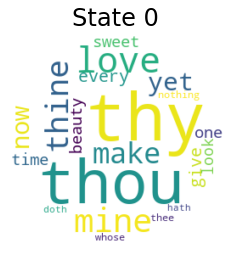

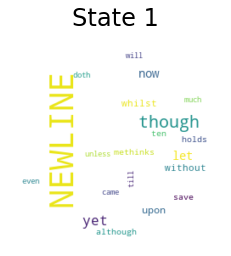

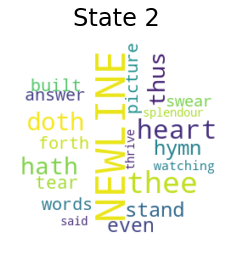

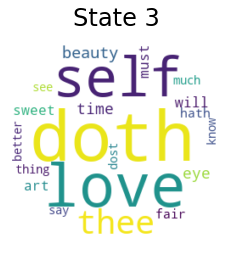

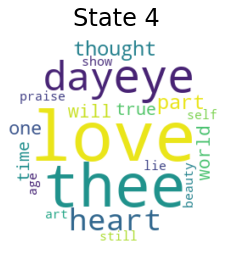

In [325]:
samps, wc = hidden_to_wordcloud(hmm_shakespeare_short, state_map_shakespeare, show=True)

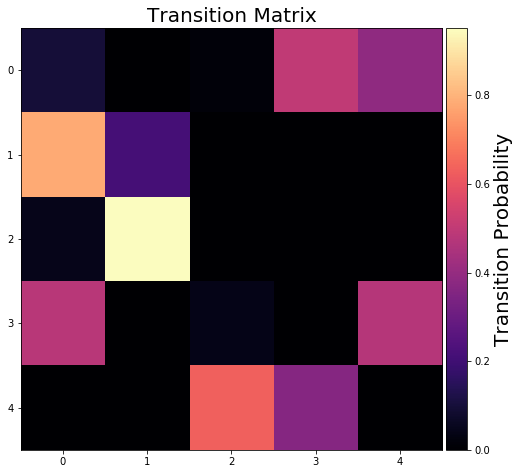

In [326]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
im = ax.imshow(hmm_shakespeare_short.A, cmap='magma')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbr = plt.colorbar(im, cax=cax)
cbr.set_label('Transition Probability', size=20)
_ = ax.set_title('Transition Matrix', size=20)

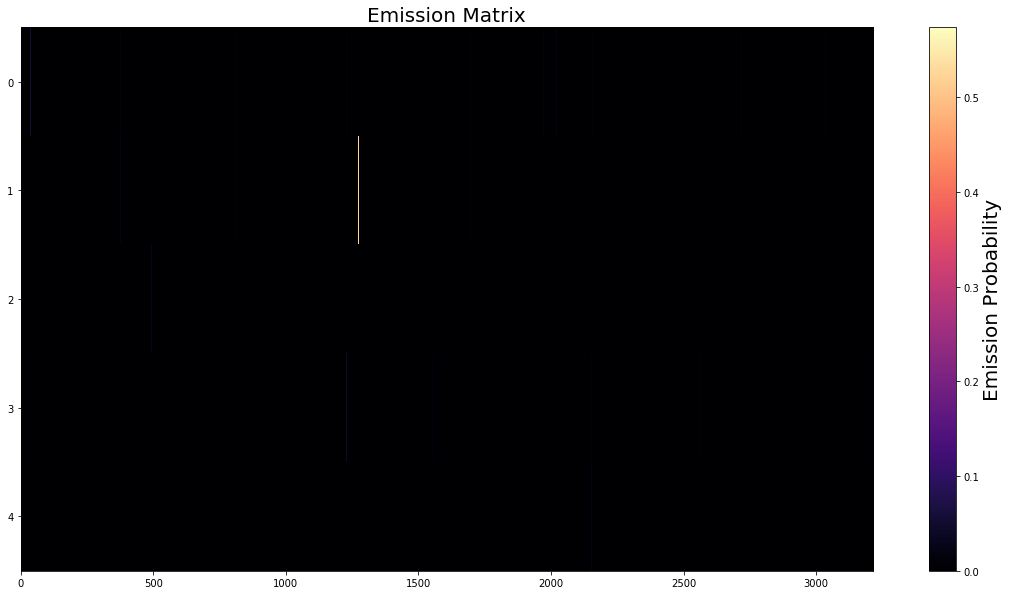

In [330]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
im = ax.imshow(hmm_shakespeare_short.O, cmap='magma', aspect=410)
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
cbr = plt.colorbar(im)
cbr.set_label('Emission Probability', size=20)
_ = ax.set_title('Emission Matrix', size=20)

## Shakespeare, 18 State HMM

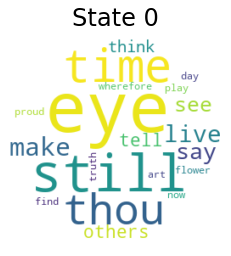

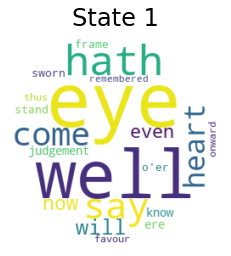

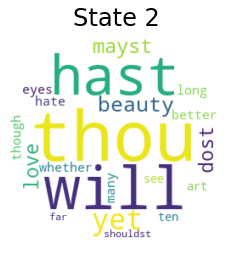

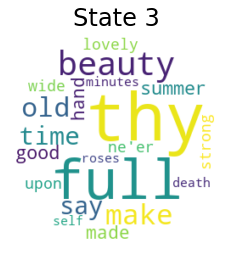

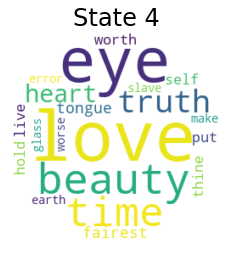

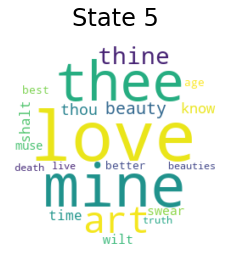

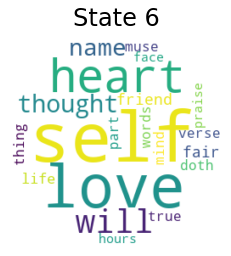

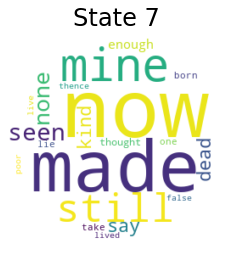

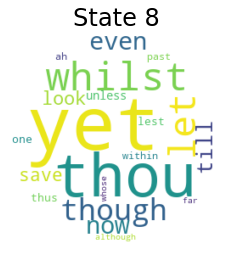

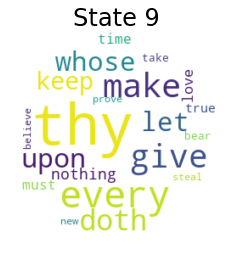

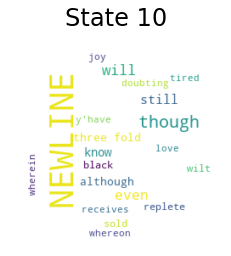

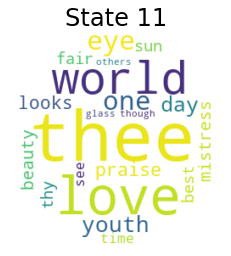

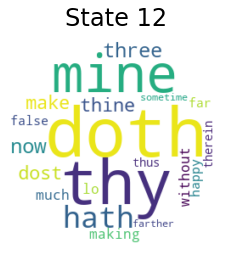

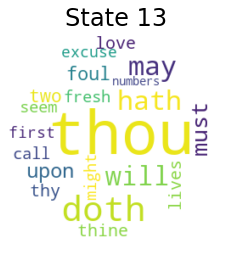

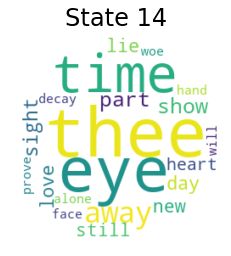

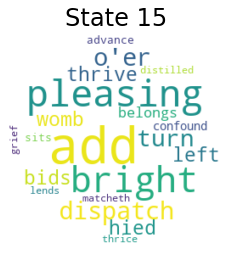

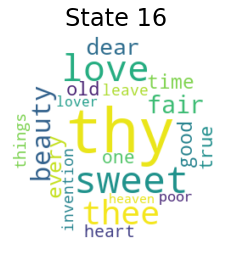

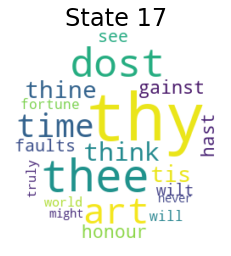

In [234]:
samps, wc = hidden_to_wordcloud(hmm_shakespeare, state_map_shakespeare, show=True)

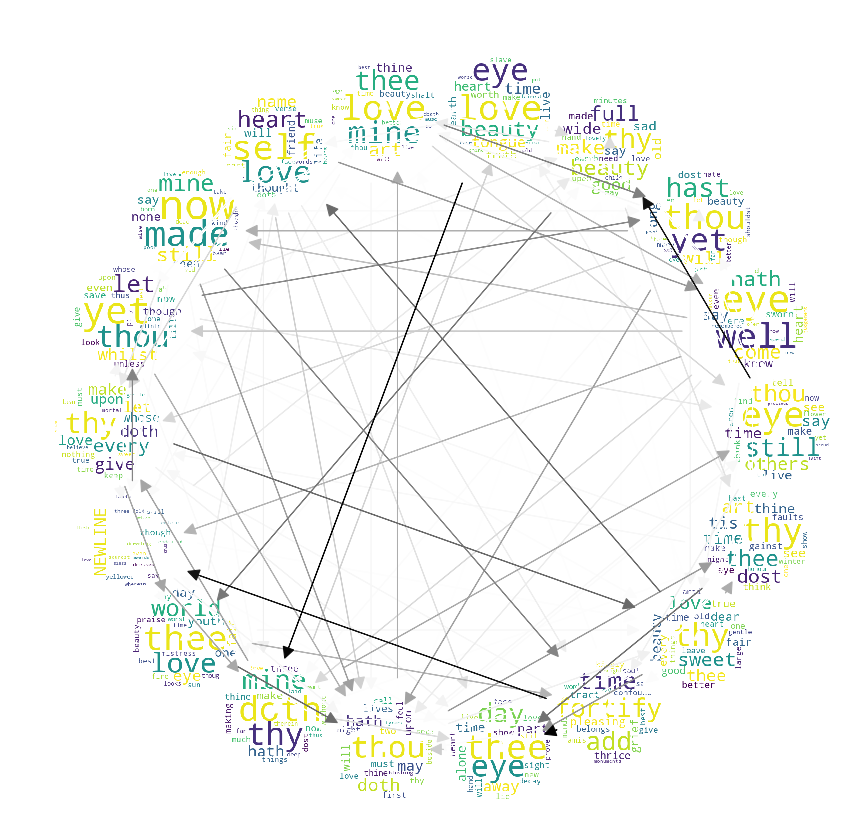

In [245]:
viz_hmm(hmm_shakespeare, state_map_shakespeare)

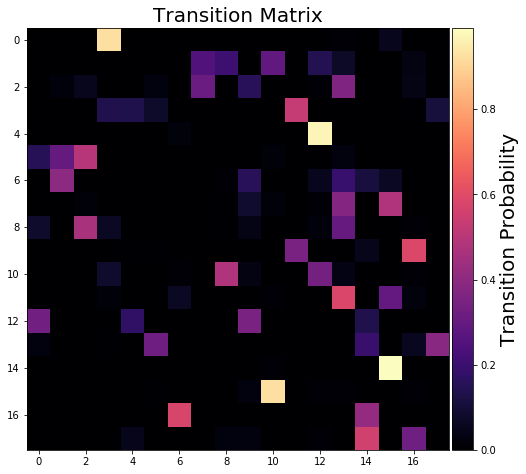

In [280]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
im = ax.imshow(hmm_shakespeare.A, cmap='magma')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbr = plt.colorbar(im, cax=cax)
cbr.set_label('Transition Probability', size=20)
_ = ax.set_title('Transition Matrix', size=20)

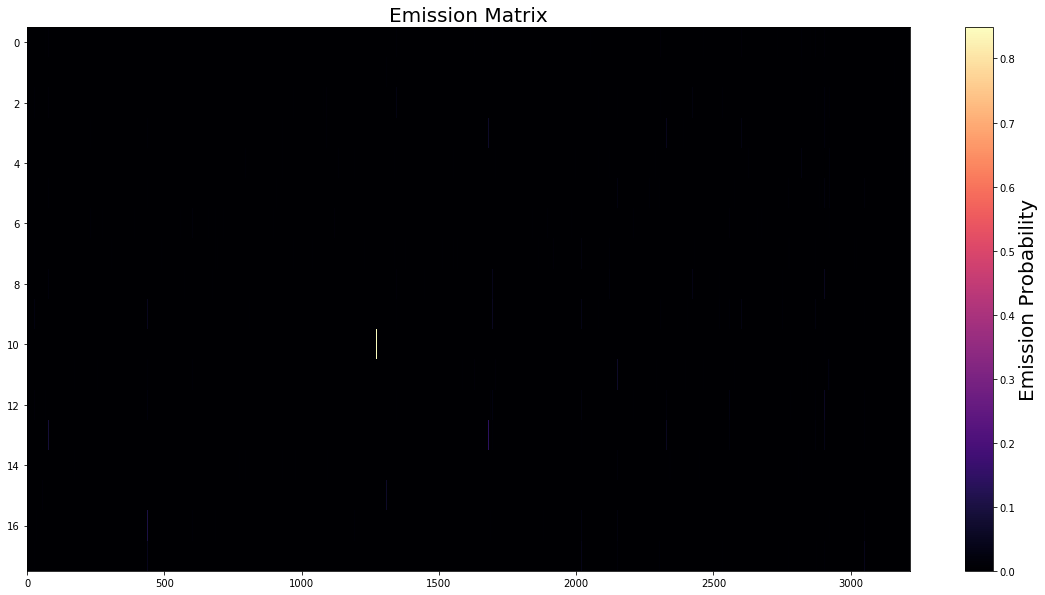

In [312]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
im = ax.imshow(hmm_shakespeare.O, cmap='magma', aspect=110)
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
cbr = plt.colorbar(im)
cbr.set_label('Emission Probability', size=20)
_ = ax.set_title('Emission Matrix', size=20)

## Full Model, 18 State HMM

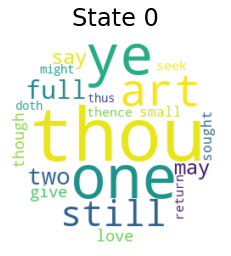

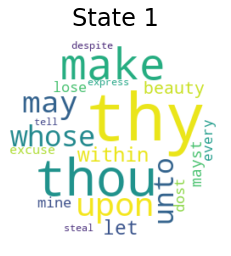

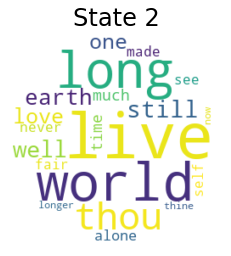

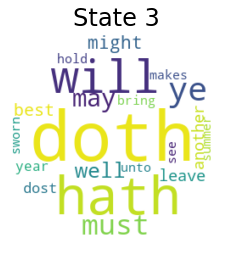

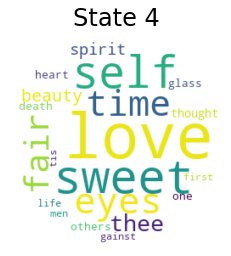

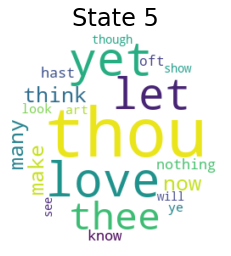

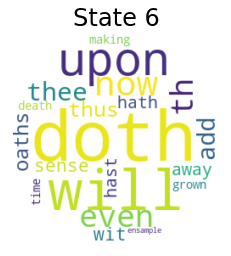

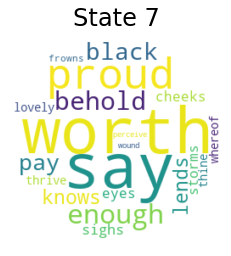

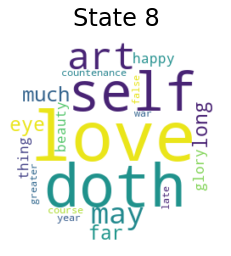

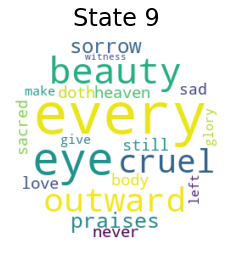

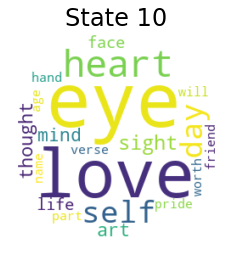

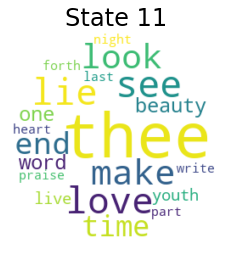

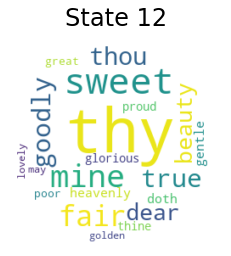

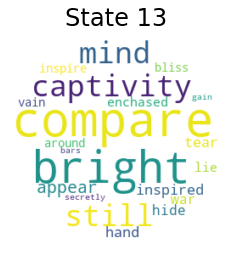

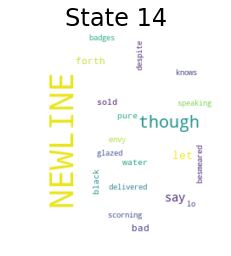

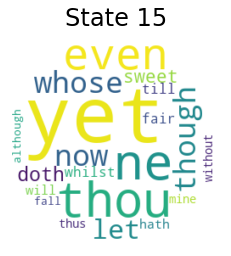

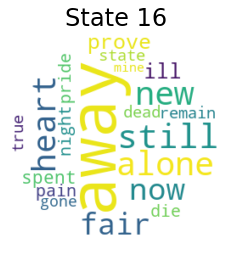

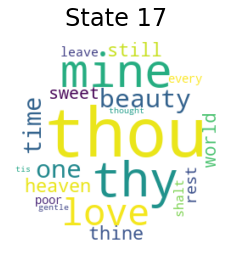

In [316]:
samps, wc = hidden_to_wordcloud(hmm_full, state_map_all, show=True)

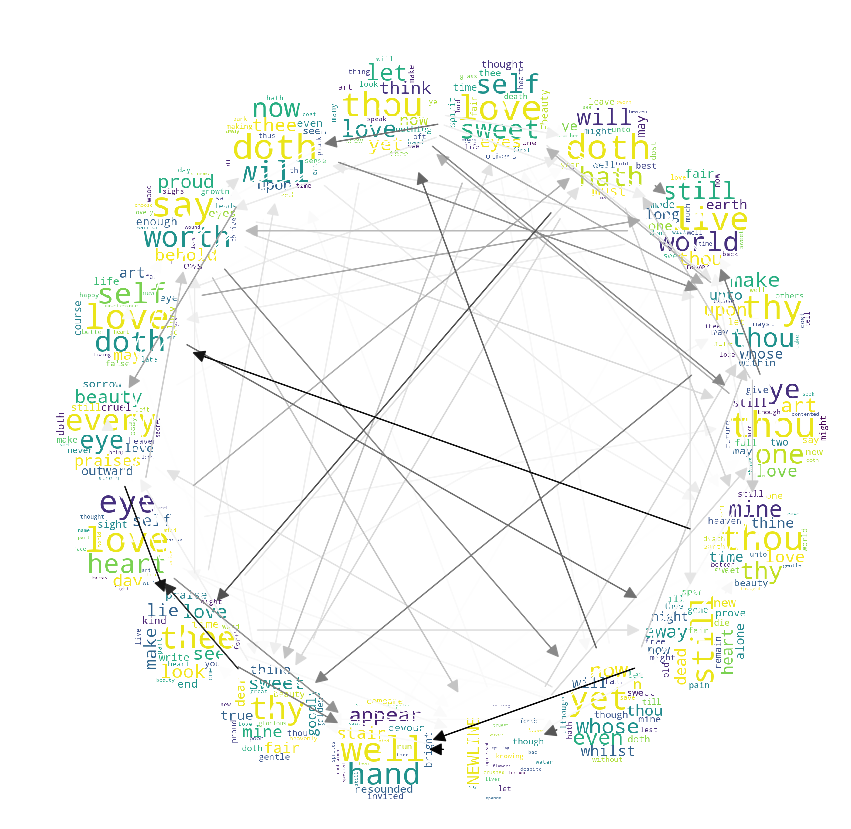

In [250]:
viz_hmm(hmm_full, state_map_all)

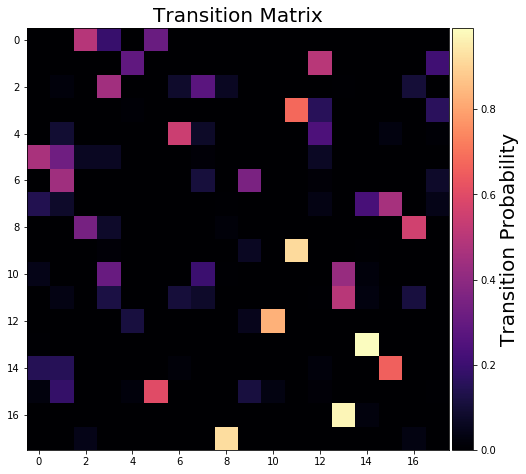

In [313]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
im = ax.imshow(hmm_full.A, cmap='magma')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbr = plt.colorbar(im, cax=cax)
cbr.set_label('Transition Probability', size=20)
_ = ax.set_title('Transition Matrix', size=20)

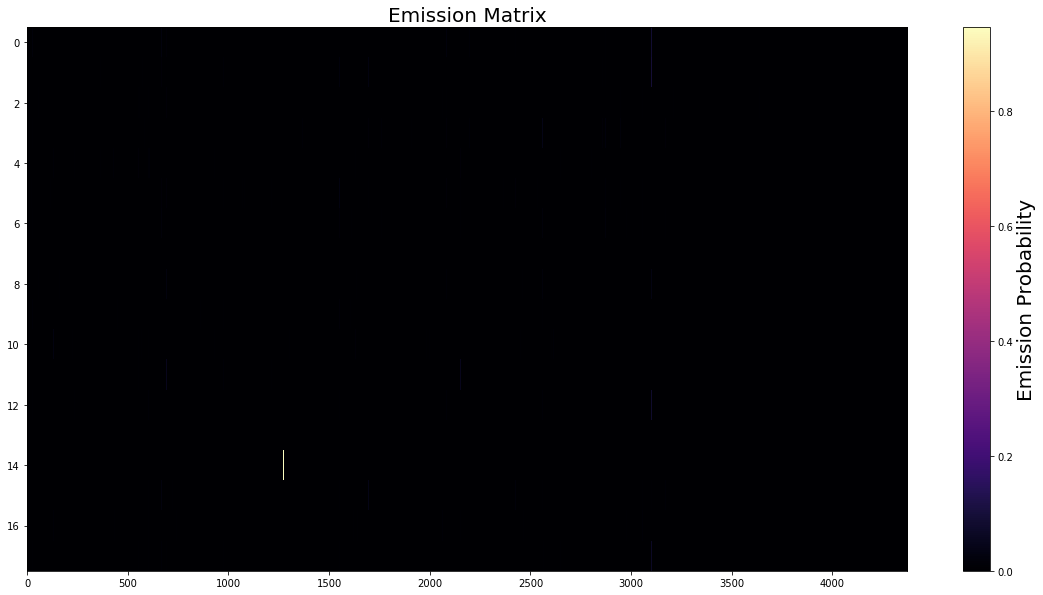

In [315]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
im = ax.imshow(hmm_full.O, cmap='magma', aspect=150)
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.05)
cbr = plt.colorbar(im)
cbr.set_label('Emission Probability', size=20)
_ = ax.set_title('Emission Matrix', size=20)